L'objectif de ce notebook est de créer un modèle qui à une question posée sur Stack Overflow associe un ou plusieurs tags. Il s'agit donc d'une classification multi-classes.

Après avoir discuté des métriques que l'on va utiliser, on effectue une première classification grâce à une approche non supervisée et l'utilisation de l'algorithme Latent dirichlet Allocation (LDA). Cette approche donne des résultats peu satisfaisants comparée à l'approche suppervisée.

Pour l'approche suppervisée, on compare les résultats d'une régression logistique avec ceux d'une SVC. Pour ces deux algorithmes on optimise les paramètres de vectorisation du corpus et des algorithmes avec des grilles de paramètres, puis par validation croisée.


# Sommaire

>[Sommaire](#scrollTo=xoxUSr-hQJGb)

>[Montage du drive](#scrollTo=ViwTxRxlFZXi)

>[Importations et options d'affichage du dataframe](#scrollTo=z69tmZ4PvGdA)

>[Fonctions du notebook d'exploration](#scrollTo=lLfN9m4pxSEy)

>[Echantillonnage, encodage de la cible, Split Train / Test](#scrollTo=StcJc4k6ZOL7)

>[I - Métriques](#scrollTo=kfZVCqElHetV)

>[II - Approche non supervisée : LDA](#scrollTo=aTbqYmq3LU4n)

>>>[Fonctions](#scrollTo=u4DmzYSbDJw-)

>>>[Avec Bow](#scrollTo=51w2TKtiWoWu)

>>>[Avec TF-IDF](#scrollTo=1MnIl8KvWr0W)

>[III - Approche supervisée](#scrollTo=lu8haQUU8_54)

>>[A - Fonction de modélisation](#scrollTo=r8LpPt2ixoZI)

>>>[Fonctions fit et predict](#scrollTo=6vZxNGLxly7p)

>>>[Fonction de test de paramètres, sans et avec CV](#scrollTo=lLxykQ-wl4s2)

>>>>[Sans CV](#scrollTo=vU-AcaAgRtCO)

>>>>[Avec CV](#scrollTo=QAKArpK3RwEd)

>>>[Fonction de visualisation des résultats](#scrollTo=M_1gNOxhmDB3)

>>[B - Modèle naïf](#scrollTo=2ZYZdAdp2s_z)

>>[C - Tests de modèles et optimisation de paramètres sans CV](#scrollTo=xg-QuuYmGDR9)

>>>[Avec une regression logistique](#scrollTo=9cYIgQSii1WG)

>>>>[Choix du Vectorizer](#scrollTo=YyZCyxcZfAgj)

>>>>[Borne inf min_df des mots peu fréquents](#scrollTo=mhEe_OR2fEsO)

>>>>[Paramètres de régularisation](#scrollTo=4Fb8HlUSfW3d)

>>>>[Nombre de tags du predict](#scrollTo=pycMMyRxfctf)

>>>>[Nombre de tags selectionnés pour entrainer le modèle](#scrollTo=wkdab04xfmvv)

>>>[Avec un classifieur SVC](#scrollTo=9G4aFAOpiset)

>>[D - Optimisation du modèle par validation croisée pour la regression logistique](#scrollTo=oxGzIgzQo2uw)

>>>[Choix du Vectorizer](#scrollTo=ykC_dgjqkvZ3)

>>>[Borne inf min_df des mots peu fréquents](#scrollTo=_s9Q3A4OkvaM)

>>>[Paramètres de régularisation](#scrollTo=9fVZy6ZAkvaQ)

>>[E - Performances du modèle en fonction du nombre minimal de tags retournés dans le predict](#scrollTo=W8UWBVPcGthj)

>>[F - Modèle choisi, visualisation des tags prédits](#scrollTo=Z05O5MLBWJHz)



# Montage du drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Importations et options d'affichage du dataframe

In [ ]:
import math
import numpy as np
import pandas as pd
import time
import re
import os.path


# Gestion des figures :
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib import colors
sns.set()

In [ ]:
# Imports NLP :

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Paramètres d'affichage des dataframes :

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)
pd.set_option('precision', 4)
pd.set_option('max_colwidth', 100)
pd.set_option('column_space', 12)

In [ ]:
# Importation des données :
chemin = '/content/drive/My Drive/Formation openclassrooms/Projets/Projet 5/Fichiers/'

df_posts = pd.read_pickle(filepath_or_buffer = chemin + '/df_posts')


In [ ]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49120 entries, 0 to 49119
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   tags                         49120 non-null  object
 1   title                        49120 non-null  object
 2   body                         49120 non-null  object
 3   tags_liste                   49120 non-null  object
 4   nb_tags                      49120 non-null  int64 
 5   tags_selection               49120 non-null  object
 6   nb_tags_selection            49120 non-null  int64 
 7   question_text                49120 non-null  object
 8   question_words_before_clean  49120 non-null  object
 9   nb_words_before_clean        49120 non-null  int64 
 10  question_words               49120 non-null  object
 11  nb_words_question            49120 non-null  int64 
 12  question_text_clean          49120 non-null  object
 13  question_words_2_uniques     49

In [ ]:
df_posts.head(3)

,tags,title,body,tags_liste,nb_tags,tags_selection,nb_tags_selection,question_text,question_words_before_clean,nb_words_before_clean,question_words,nb_words_question,question_text_clean,question_words_2_uniques,nb_uniques_words
0,<php><file><file-upload>,How to limit file upload type file size in PHP?,<p>I have an upload form and am checking the file size and file type to limit the uploaded file ...,"[php, file, file-upload]",3,"[file-upload, file, php]",3,How to limit file upload type file size in PHP? I have an upload form and am checking the file s...,"[how, to, limit, file, upload, type, file, size, in, php, i, have, an, upload, form, and, am, ch...",203,"[limit, file, upload, file, size, php, upload, form, check, file, size, file, limit, upload, fil...",126,limit file upload file size php upload form check file size file limit upload file megabyt eithe...,"[limit, file, upload, size, php, form, check, either, pdf, jpg, gif, png, goal, alert, messag, d...",47
1,<sql><sql-server><oracle><syntax><case>,SQL Case Expression Syntax?,<p>What is the <strong>complete</strong> and correct syntax for the SQL Case expression?</p>\n,"[sql, sql-server, oracle, syntax, case]",5,"[oracle, syntax, sql, sql-server]",4,SQL Case Expression Syntax? What is the complete and correct syntax for the SQL Case expression?\n,"[sql, case, expression, syntax, what, is, the, complete, and, correct, syntax, for, the, sql, ca...",16,"[sql, case, express, syntax, complet, correct, syntax, sql, case, express]",10,sql case express syntax complet correct syntax sql case express,"[correct, sql, case, express, syntax, complet]",6
2,<fonts><development-environment>,Recommended Fonts for Programming?,"<p>What fonts do you use for programming, and for what language/IDE? I use <a href=""http://www....","[fonts, development-environment]",2,[fonts],1,"Recommended Fonts for Programming? What fonts do you use for programming, and for what language/...","[recommended, fonts, for, programming, what, fonts, do, you, use, for, programming, and, for, wh...",28,"[recommend, font, program, font, program, languag, ide, consola, visual, studio, ani, recommend]",12,recommend font program font program languag ide consola visual studio ani recommend,"[ani, recommend, font, program, languag, ide, visual, studio]",8


# Fonctions du notebook d'exploration

Voici quelques fonction présentes dans le premier notebook et que nous réutilisons ici.  
Les deux premières fonction servent à selectionner les tags les plus fréquents, et la 3ème est la fonction de vectorisation d'un corpus de textes.

In [ ]:
# Fonction qui prend une tokenisation d'un corpus (série de listes de mots)
# et qui retourne les fréquences du corpus, données par un objet de classe nltk.FreqDist.
# Si mots_uniques == True, la fonction ne compte pas les mots multiples dans une phrase.

def fonction_frequences(serie_tokenisations, mots_uniques=False):
    liste_tokens = []
    for liste in serie_tokenisations:
        if mots_uniques:
            liste = list(set(liste))
        liste_tokens += liste

    return nltk.FreqDist(liste_tokens)


In [ ]:
# Fonction qui permet de ne conserver que les tags selectionnés dans notre dataframe :
# Les tags selectionnés sont les nb_tags_selectionnes les plus fréquents :

def selection_tags(serie_tags, nb_tags):
    tags_frequences = fonction_frequences(serie_tags)
    most_common = [couple[0] for couple in tags_frequences.most_common(nb_tags)]

    return serie_tags.apply(lambda liste_tags: list(set(liste_tags).intersection(set(most_common))))
    

In [ ]:
# Fonction qui réalise la vectorisation d'un corpus de texte, avec aux choix un bo(w ou n-gram) ou tf-idf :
# Les paramètres sont les suivants :
    # serie_str est le corpus de textes
    # vectorizer_type est de type 'bow' ou 'tfidf'
    # binary == True permet de ne pas compter les multiplicités dans un texte
    # ngram_range donne l'option de choisir des n-grams (ce sont des mots par défaut)

# La fonction retourne le triplet constitué du vocabulaire selectionné (dans le même ordre que la vectorisation), de la vectorisation des données X, et du vectorizer.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def vectorizer_function(serie_str, vectorizer_type, min_df, binary=False, ngram_range = (1,1)):
    if vectorizer_type == 'bow':
        vectorizer = CountVectorizer(min_df=min_df, binary=binary, ngram_range=ngram_range, token_pattern='[A-Za-z][A-Za-z0-9_+\-#]*')
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, binary=binary, ngram_range=ngram_range, token_pattern='[A-Za-z][A-Za-z0-9_+\-#]*')
    
    X = vectorizer.fit_transform(serie_str)

    vocab = sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])
    
    vocabulary = []
    for couple in vocab:
        vocabulary.append(couple[0])

    return (vocabulary, X, vectorizer)


# Echantillonnage, encodage de la cible, Split Train / Test

Etant donné que les modèles sont assez lourds et que l'on ne dispose pas de la puissance de calcul et du temps nécessaires pour bien optimiser les paramètres des modèles, on se restreint à un échantillon de 20k et 300 tags, que l'on sépare en données d'entrainement et de test avec un rapport de 75/25 %.

In [ ]:
from sklearn.model_selection import train_test_split

# Echantillon :
sample_size = 20000

# df_sample = df_posts.sample(sample_size)

# df_sample.to_pickle(path = chemin + 'df_sample')


In [ ]:
df_sample = pd.read_pickle(filepath_or_buffer = chemin + 'df_sample')

df_sample_train, df_sample_test = train_test_split(df_sample, test_size=0.25)

X_sample = df_sample.question_text_clean
y_sample = df_sample.tags_liste

X_sample_train = df_sample_train.question_text_clean
y_sample_train = df_sample_train.tags_liste

X_sample_test = df_sample_test.question_text_clean
y_sample_test = df_sample_test.tags_liste

In [ ]:
# Pour le modèle final, sur toutes les données : 

df_train, df_test = train_test_split(df_posts, test_size=0.25)

X_train = df_train.question_text_clean
y_train = df_train.tags_liste

X_test = df_test.question_text_clean
y_test = df_test.tags_liste

# I - Métriques

Pour évaluer la prédiction d'un ensemble de tags par rapport à un ensemble de tags réels, la métrique la plus naturelle est l'indice de Jaccard, qui mesure la proportion de tags communs aux deux ensembles par rapport à l'union des tags des deux ensembles, c'est à dire le cardinal de l'intersection sur le cardinal de l'union.  
Une autre approche consiste à sytématiquement proposer plus de tags pour la prédiction que le nombre réel, dans ce cas il est plus judicieux de regarder la proportion de tags communs aux deux ensembles par rapport à l'ensemble des tags réels, c'est à dire le cardinal de l'intersection sur le cardinal de l'ensemble des tags réels. On notera par la suite cette métrique "true predict / true".  
La fonction suivante gère les 2 métriques à la fois, avec l'option "custom = True" pour la métrique "true predict / true". La métrique existe sous sklearn mais elle ne gère pas les ensembles vides, donc on la recode ici.

In [ ]:
from sklearn.metrics import jaccard_score

# Sinon fonction faite maison, qui gère les listes vides...

def jaccard(list1, list2, custom=False):
    union = set(list1 + list2)
    intersection = set(list1).intersection(set(list2))
    if len(union) == 0:
        return 100.
    elif custom:
        if len(list1) == 0:
            return 100.
        return 100*len(intersection)/len(list1)
    else:
        return 100*len(intersection)/len(union)

In [ ]:
# Lorsque les cibles et prédiction sont vides :
jaccard([], [])

100.0

In [ ]:
list1, list2 = ['python', 'pandas'], ['python', 'dataframe', 'numpy']

print('Exemple :\n   Tags réels = y_true = {},\n   Tags prédits = y_pred = {}'.format(list1, list2),'\n')
print('Score de Jaccard = 1 tag en commun sur 4 = ', '{:.2f} %'.format(jaccard(list1, list2, custom=False)))
print('true_predict/true = 1 tag en commun sur 2 possibles = {} %'.format(jaccard(list1, list2, custom=True)))


Exemple :
   Tags réels = y_true = ['python', 'pandas'],
   Tags prédits = y_pred = ['python', 'dataframe', 'numpy'] 

Score de Jaccard = 1 tag en commun sur 4 =  25.00 %
true_predict/true = 1 tag en commun sur 2 possibles = 50.0 %


In [ ]:
# Retourne la série de scores de Jaccard calculés avec la série des tags réel et la série des tags prédits

def jaccard_2(tags_true, tags_predict, custom=False):
    df = pd.DataFrame(tags_true)
    df['tags_predictions'] = tags_predict
    df['jaccard_score'] = df.apply(lambda row: jaccard(row[tags_true.name], row.tags_predictions, custom), axis=1)
    return df['jaccard_score']

# II - Approche non supervisée : LDA

Avec la LDA (Latent Dirichlet Allocation), nous pouvons assigner au corpus un ensemble de thèmes (topics). Pour chaque question du corpus on obtient une probabilité d'appartenance à chacun des thèmes. On peut alors assigner à une question les mots qui sont le plus liés aux thèmes de la question.

### Fonctions

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Fonction qui entraine une LDA, à partir du corpus X_text (série de str) et retourne le modèle
# Paramètres :
    # n_topics est le nombre de topics choisi
    # nb_top_words est le nombre de mots affichés par topic
    # vectorizer_type et min_df sont les paramètres de vectorisation du corpus
    # display_model permet en option d'afficher les mots des différents topics

def lda_fit(X_text, n_topics, nb_top_words=10, vectorizer_type='tfidf', min_df=50, display_model=True):

    # Vectorisation du corpus
    (vocabulary, X, vectorizer) = vectorizer_function(df_sample.question_text_clean, vectorizer_type=vectorizer_type, min_df=min_df)

    # Paramètres de la LDA
    lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50,
            random_state=0)

    start_time = time.time()
    lda.fit(X)
    print("--- {:.2f} seconds ---".format(time.time() - start_time))

    # Affichage des topics en option :
    if display_model:
        # print('Perplexité = ', lda.perplexity(X))
        # print('Score = ', lda.score(X), '\n')
        columns = ['num_topic'] + ['word_{}'.format(i) for i in range(nb_top_words)]
        df = pd.DataFrame()
        for topic_idx, topic in enumerate(lda.components_):
            row = pd.DataFrame([["Topic {}".format(topic_idx)] + [vocabulary[i] for i in topic.argsort()[:-nb_top_words - 1:-1]]], index = [topic_idx], columns=columns)
            df = pd.concat([df, row])
        display(df)
            
    return lda


In [ ]:
# Fonction pour récupérer les tags dans les listes de mots par topic
def return_tags(row, serie_topic, n_topics):
    liste_tags = []
    for i in range(n_topics):
        if row[i] > 0:
            liste_tags += serie_topic[i][:row[i]]
    return liste_tags


# Fonction qui fit la LDA et retourne les listes de mots associées à chaque question du corpus

def lda_fit_transform(X_text, n_topics, nb_top_words=10, vectorizer_type='tfidf', min_df=50, affiche_topics=False):
    # Vectorisation du corpus
    (vocabulary, X, vectorizer) = vectorizer_function(X_text, vectorizer_type=vectorizer_type, min_df=min_df)

    # Paramètres de la LDA
    lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50,
            random_state=0)

    start_time = time.time()
    X_transform = lda.fit_transform(X)
    print("--- {:.2f} seconds ---".format(time.time() - start_time))


    #print('Perplexité = ', lda.perplexity(X))
    #print('Score = ', lda.score(X), '\n')
    
    # On créer la liste des top words pour chaque topic
    serie_topic = pd.Series(dtype='object')
    for topic_idx, topic in enumerate(lda.components_):
        serie_topic['topic_' + str(topic_idx)] = [vocabulary[i] for i in topic.argsort()[:-nb_top_words - 1:-1]]
    if affiche_topics:
        display(serie_topic), print()
    
    # A partir de ces top words, on associe un ensemble de mots à chaque question, grâce à la fonction précédente return_tags :
    X_transform = pd.DataFrame(X_transform)
    for col in X_transform.columns:
        X_transform[col] = X_transform[col].apply(lambda x : int(nb_top_words*x))
    return X_transform.apply(lambda row : return_tags(row, serie_topic, n_topics), axis=1)


In [ ]:
# Fonction d'affichage des questions et des tags retournés :

def visualisation_lda(df, n_topics, nb_top_words=10, vectorizer_type='tfidf', min_df=50):
    start_time = time.time()
    df_return = df[['question_text', 'tags_liste']].copy()
    df_return.index = range(len(df_return))

    df_return['tags_predict'] =  lda_fit_transform(df.question_text_clean, n_topics=n_topics, nb_top_words=nb_top_words, vectorizer_type=vectorizer_type, affiche_topics=True) 

    print("--- {:.2f} seconds ---".format(time.time() - start_time))

    return df_return

### Avec Bow

In [ ]:
# Topics

df = visualisation_lda(df_sample, n_topics=20, nb_top_words=10, vectorizer_type='bow', min_df=10)

In [ ]:
# Exemple avec une question :

mask = df.tags_liste.apply(lambda liste: 'git' in liste)

df[mask].head()

### Avec TF-IDF

In [ ]:
df = visualisation_lda(df_sample, n_topics=20, nb_top_words=10, vectorizer_type='tfidf', min_df=20)

In [ ]:
# Exemple avec une question :

mask = df.tags_liste.apply(lambda liste: 'git' in liste)

df[mask].iloc[-5]

# III - Approche supervisée

Pour l'approche supervisée il s'agit d'une prédiction multi-labels. Pour chaque tag du modèle, on réalise une classification binaire pour chaque question : soit le tag est associé à la question, soit il ne l'est pas. Le nombre de tags que l'on regarde (les plus fréquents) est l'un des paramètre du modèle.
Les 2 classifieurs que l'on utilise ici sont le SVC et la régression logistique.  
Si l'on choisit les 100 tags les plus fréquents, le modèle est donc constitué de 100 classifieurs binaires. On peut récupérer les fonctions de décisions pour chaque classifieur, afin de prédire pour chaque question les n tags les plus probables, et non pas seulement les tags pour lesquels la fonction de décision est positive. Cela va nous permettre d'améliorer les performances de notre modèle.

In [ ]:
# Pour le one hot encoding des tags :
from sklearn.preprocessing import MultiLabelBinarizer

# Classifieur multiclasses :
from sklearn.multioutput import MultiOutputClassifier
# Malheureusement je ne peux pas paralléliser, j'ai des erreurs avec colab...

# Nos modèles de classification, qui supportent des matrices creuses :
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


## A - Fonction de modélisation

### Fonctions fit et predict

In [ ]:
# Fonction qui entraine le modèle à partir des paramètres suivants :

# n_tags_selection est le nombre de tags parmi les plus fréquents utilisés par le modèle
# clf est un classifieur booléen (qui accepte les matrices creuses, ex SVC, regr logistique)
# le corpus est la série de str sur lequel on fait la vectorisation
# targets_tags est la série donnant les listes de tags cibles
# la vectorisation est soit de type 'bow' ou 'tfidf', avec le paramètre min_df

# La fonction retourne le modèle entrainé composé du triplet suivant :
    # le classifieur multi-labels MultiOutputClassifier
    # le vectorizer 
    # le multiLabelBinarizer

def model_fit(corpus, target_tags, n_tags_selection, clf, vectorizer_type='bow', min_df=50):
    # On entraine le vectorizer sur le corpus, avec les paramètres vectorizer_type et min_df
    (vocabulary, X, vectorizer) = vectorizer_function(corpus, vectorizer_type=vectorizer_type, min_df=min_df)
    
    # On selectionne les tags les plus fréquents puis on les code avec le multiLabelBinarizer :
    target_tags = selection_tags(target_tags, n_tags_selection)
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(target_tags)

    # Enfin on entraine un classifieur clf pour chaque tag :
    classif_multi_labels = MultiOutputClassifier(clf)
    classif_multi_labels.fit(X, y)

    # On retourne le modèle :
    return (classif_multi_labels, vectorizer, mlb)


In [ ]:
# Fonction pour selectionner les tags pour lesquels la fonction de décision associée est positive +
# un minimum de n_tags_min qui ont les meilleurs fonctions de décision.

def fonction_selection_tags(row, n_tags_min):
    row = row.sort_values(ascending=False)
    liste_tags = list(row[:n_tags_min].index)
    row = row[n_tags_min:]
    mask = row >= 0
    liste_tags += list(row[mask].index)
    return liste_tags


# Fonction qui retourne les tags prédits à partir du modèle

def model_predict(corpus, model, n_tags_min=3):
    
    (classif_multi_classes, vectorizer, mlb) = model
    X = vectorizer.transform(corpus)
    df = pd.DataFrame(corpus)
    # Calcul des fonctions de décisions :
    for i, estimator in enumerate(classif_multi_classes.estimators_):
        df[mlb.classes_[i]] = estimator.decision_function(X)
    predict = df.apply(lambda row: fonction_selection_tags(row[1:], n_tags_min), axis=1)
    return predict

In [ ]:
# Test de la fonction_selection_tags :
serie = pd.Series([1, 2, -1, -2, -3, -6], index=['python', 'pandas', 'numpy', 'python2', 'pandas2', 'numpy2'])
fonction_selection_tags(serie, 4)

['pandas', 'python', 'numpy', 'python2']

### Fonction de test de paramètres, sans et avec CV

#### Sans CV

In [ ]:
from sklearn.model_selection import ParameterGrid

# Fonction qui entraine le modèle avec les paramètres donnés par les grilles params_grid et params_grid_clf,
# et qui retourne un dataframe des résultats pour chaque choix de paramètres.


def model_test_params(X_train, y_train, X_test, y_test, params_grid={}, params_grid_clf={}):
    df_results = pd.DataFrame()
    params_grid = ParameterGrid(params_grid)
    params_grid_clf = ParameterGrid(params_grid_clf)

    # Boucle pour la grille de paramètres (clf, vectorizer_type, min_df)
    for params in params_grid:
        # Sous-boucle pour la grille de paramètres du classifieur clf :
        for params_clf in params_grid_clf:
            # Le dictionnaire des paramètres :
            dico_parametres_resultats = {'classifieur_binaire':[params['clf'].__name__ + ' ' + str(params_clf)],\
                            'n_tags_selection':[params['n_tags_selection']], 'n_tags_min':[params['n_tags_min']], 'vectorizer_type':[params['vectorizer_type']], 'min_df':[params['min_df']]}

            # On enregistre le temps d'éxécution pour chaque choix de paramètres :
            start_time = time.time()
            
            # On fit le modèle avec les données d'entrainement et on calcule les prédiction sur les données de test :
            model = model_fit(X_train, y_train, params['n_tags_selection'], clf=params['clf'](**params_clf), vectorizer_type=params['vectorizer_type'], min_df=params['min_df'])
            y_predict = model_predict(X_test, model, n_tags_min=params['n_tags_min'])

            # Calcul des métriques moyennes
            jaccard = jaccard_2(y_test, y_predict, custom=False).mean()
            true_predict_vs_true = jaccard_2(y_test, y_predict, custom=True).mean()

            # Passage des résultats dans le dico, puis ajout au Df :
            dico_parametres_resultats['time'] = [time.time() - start_time]
            dico_parametres_resultats['jaccard_indice'] = [jaccard]
            dico_parametres_resultats['true_predict/true'] = [true_predict_vs_true]
            df_results = df_results.append(pd.DataFrame(dico_parametres_resultats))

    # Ajout des rangs de chaque choix de paramètres pour les 2 métriques :
    df_results['rang_jaccard_indice'] = df_results['jaccard_indice'].rank(ascending=False).apply(int)
    df_results['rang_true_predict/true'] = df_results['true_predict/true'].rank(ascending=False).apply(int)

    return df_results

In [ ]:
# Fonction associée à model_test_params pour enregistrer les résultats sur un fichier, avec l'option recompute.

def model_test_params_2(nom_fichier, params_grid={}, params_grid_clf={}, recompute=False, alldata=False):
    # recompute=True
    # Si on décide de recalculer le résultat, ou que le fichier n'existe pas encore
    if recompute or not os.path.isfile(chemin + nom_fichier):
        if alldata:
            resultat = model_test_params(X_train, y_train, X_test, y_test, params_grid=params_grid, params_grid_clf=params_grid_clf)
        else:
            resultat = model_test_params(X_sample_train, y_sample_train, X_sample_test, y_sample_test, params_grid=params_grid, params_grid_clf=params_grid_clf)
        resultat.to_pickle(path = chemin + nom_fichier)
        return resultat        
    else:
        return pd.read_pickle(filepath_or_buffer = chemin + nom_fichier)




#### Avec CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Même fonction avec validation croisée :

def model_test_params_cv(X, y, n_splits=3, params_grid={}, params_grid_clf={}):
    df_results = pd.DataFrame()
    params_grid = ParameterGrid(params_grid)
    params_grid_clf = ParameterGrid(params_grid_clf)

    kf = KFold(n_splits=n_splits)
    kf.get_n_splits()

    # Boucle pour la grille de paramètres (clf, vectorizer_type, min_df)
    for params in params_grid:
        # Sous-boucle pour la grille de paramètres du classifieur clf :
        for params_clf in params_grid_clf:
            dico_parametres_resultats = {'classifieur_binaire':[params['clf'].__name__ + ' ' + str(params_clf)],\
                            'n_tags_selection':[params['n_tags_selection']], 'n_tags_min':[params['n_tags_min']], 'vectorizer_type':[params['vectorizer_type']], 'min_df':[params['min_df']]}
            
            start_time = time.time()
            # Boucle pour les KF :
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                model = model_fit(X_train, y_train, params['n_tags_selection'], clf=params['clf'](**params_clf), vectorizer_type=params['vectorizer_type'], min_df=params['min_df'])
                y_predict = model_predict(X_test, model, n_tags_min=params['n_tags_min'])

                jaccard = jaccard_2(y_test, y_predict, custom=False).mean()
                true_predict_vs_true = jaccard_2(y_test, y_predict, custom=True).mean()
                
                dico_parametres_resultats['Jaccard_KF_' + str(i)] = [jaccard]
                dico_parametres_resultats['true_predict/true_KF_' + str(i)] = [true_predict_vs_true]

            dico_parametres_resultats['time'] = [time.time() - start_time]
            df_results = df_results.append(pd.DataFrame(dico_parametres_resultats))
            
            df_results['jaccard_indice_moy'] = df_results.apply(lambda row : row[['Jaccard_KF_' + str(i) for i in range(n_splits)]].mean(), axis=1)
            df_results['true_predict/true_moy'] = df_results.apply(lambda row : row[['true_predict/true_KF_' + str(i) for i in range(n_splits)]].mean(), axis=1)
        
            df_results['rang_jaccard_indice'] = df_results['jaccard_indice_moy'].rank(ascending=False).apply(int)
            df_results['rang_true_predict/true'] = df_results['true_predict/true_moy'].rank(ascending=False).apply(int)

    return df_results



In [ ]:
# Fonction associée à model_test_params_cv pour enregistrer les résultats sur un fichier, avec l'option recompute.

def model_test_params_cv_2(nom_fichier, params_grid={}, params_grid_clf={}, drop_affichage_KF=True, recompute=False):
    # recompute=True
    if recompute or not os.path.isfile(chemin + nom_fichier):
        resultat = model_test_params_cv(X_sample, y_sample, params_grid=params_grid, params_grid_clf=params_grid_clf)
        if drop_affichage_KF:
            resultat.drop(labels=['Jaccard_KF_' + str(i) for i in range(3)] + ['true_predict/true_KF_' + str(i) for i in range(3)], axis=1, inplace=True)
        resultat.to_pickle(path = chemin + nom_fichier)
        return resultat        
    else:
        return pd.read_pickle(filepath_or_buffer = chemin + nom_fichier)

### Fonction de visualisation des résultats

In [ ]:
# Fonction qui prend en paramètres les dataframes d'entrainement et de test, et les paramètres du modèle.
# La fonction entraine le modèle et retourne le dataframe de test avec les tags predits pour n_tags_min=0 et n_tags_min=n_tags.

def visualisation_resultats(df_train, df_test, params, n_tags=3):
    start_time = time.time()
    
    X_train = df_train.question_text_clean
    y_train = df_train.tags_liste
    X_test = df_test.question_text_clean
    y_test = df_test.tags_liste

    # On entraine le modèle à partir des données d'entrainement
    model = model_fit(X_train, y_train, params['n_tags_selection'], clf=params['clf'], vectorizer_type=params['vectorizer_type'], min_df=params['min_df'])
    
    # On calcule les tags prédit sur les données de test :
    y_predict_0 = model_predict(X_test, model, n_tags_min=0)
    y_predict = model_predict(X_test, model, n_tags_min=params['n_tags_min'])

    df = df_test[['question_text', 'tags_liste']].copy()

    df['tags_predict_fct_decision >= 0'] = y_predict_0
    df['tags_predict'] = y_predict


    df['jaccard_indice'] = jaccard_2(y_test, y_predict, custom=False)
    df['true_predict/true'] = jaccard_2(y_test, y_predict, custom=True)

    print("--- {:.2f} seconds ---".format(time.time() - start_time))
    print('Indice de Jaccard moyen = {:.4f}'.format(df['jaccard_indice'].mean()))
    print('Indice true_predict/true moyen = {:.4f}'.format(df['true_predict/true'].mean()))
    return df


## B - Modèle naïf

Avant de commencer à optimiser nos modèles, on peut observer ce que donnent nos deux métriques sur un modèle naïf, qui retourne systématiquement la liste des n tags les plus fréquents. Cela nous donnera une bonne base de comparaison.

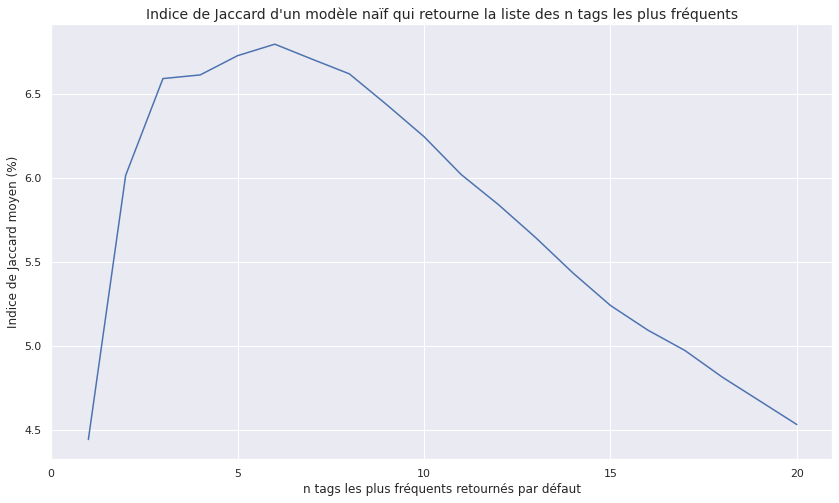

In [ ]:
# Pour l'indice de Jaccard sur les données de test

liste_tags_les_plus_frequents = ['javascript', 'java', 'python', 'c#', 'html', 'jquery', 'android', 'css', 'php', 'sql', 'mysql', 'string', 'sql-server', 'c++', 'net', 'git', 'arrays', 'linux', 'c', 'json']

X = range(1, 21)
Y1 = []

n =len(df_sample_test)
for i in X:
    Y1.append(jaccard_2(df_sample_test.tags_liste, [liste_tags_les_plus_frequents[:i]]*n, custom=False).mean())

plt.figure(figsize=(14,8))

plt.plot(X, Y1)
plt.xticks(range(0,25,5))
plt.xlabel('n tags les plus fréquents retournés par défaut')
plt.ylabel('Indice de Jaccard moyen (%)')
plt.title('Indice de Jaccard d\'un modèle naïf qui retourne la liste des n tags les plus fréquents', size=14)

plt.show()


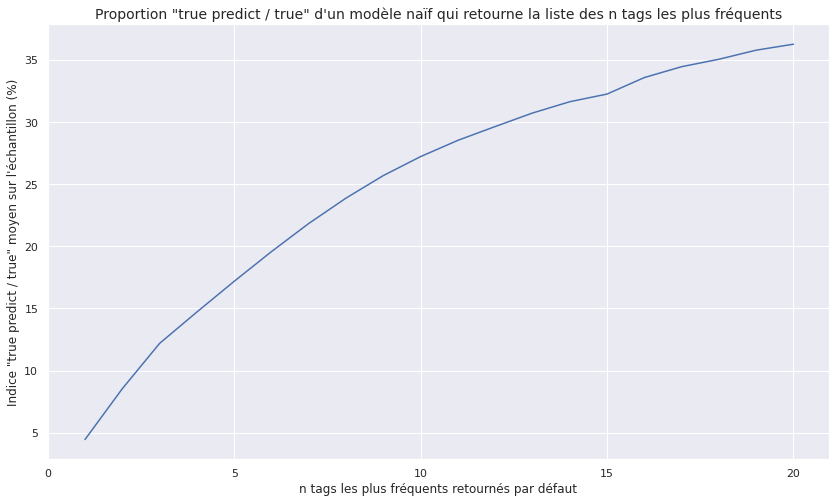

In [ ]:
# Pour la proportion de vrais tags prédits parmi les les vrais tags, toujour sur les données de test :

liste_tags_les_plus_frequents = ['javascript', 'java', 'python', 'c#', 'html', 'jquery', 'android', 'css', 'php', 'sql', 'mysql', 'string', 'sql-server', 'c++', 'net', 'git', 'arrays', 'linux', 'c', 'json']

X = range(1, 21)
Y2 = []

n =len(df_sample_test)
for i in X:
    Y2.append(jaccard_2(df_sample_test.tags_liste, [liste_tags_les_plus_frequents[:i]]*n, custom=True).mean())

plt.figure(figsize=(14,8))

plt.plot(X, Y2)
plt.xticks(range(0,25,5))
plt.xlabel('n tags les plus fréquents retournés par défaut')
plt.ylabel('Indice "true predict / true" moyen sur l\'échantillon (%)')
plt.title('Proportion "true predict / true" d\'un modèle naïf qui retourne la liste des n tags les plus fréquents', size=14)

plt.show()


## C - Tests de modèles et optimisation de paramètres sans CV

Nous allons optimiser les différents paramètres de notre modèle, nous observons d'abord les paramètres sans validation croisée, puis nous confirmons les choix définitifs avec.  

Quelques commentaires sur les paramètres du modèle :  
Le nombre de tags selectionnés n'est pas un paramètre à optimiser, mais plutôt un choix pour ne pas avoir un modèle trop lourd, pour optimiser les autres paramètres nous nous limitons à n_tags_selection = 150.  
Le nombre de tags minimal à prédire grâce aux fonctions de décision est plus un choix cohérent qu'un choix d'optimisation de métrique.

### Avec une regression logistique

#### Choix du Vectorizer

In [ ]:
# Optimisations 'vectorizer_type' bow ou tfidf :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[150], 'n_tags_min':[5], 'vectorizer_type':['bow', 'tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l1']}

df_resultats_reg_log_0 = model_test_params_2('df_resultats_reg_log_0', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_0)

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,5,bow,6,32.7587,22.8312,51.7563,2,2
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,16.2841,23.8154,53.3937,1,1


#### Borne inf min_df des mots peu fréquents

In [ ]:
# Optimisations 'min_df' :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[150], 'n_tags_min':[3], 'vectorizer_type':['tfidf'], 'min_df':list(range(2,4)) + list(range(4,10,2)) + list(range(10,35,5))}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l1']}

df_resultats_reg_log_1 = model_test_params_2('df_resultats_reg_log_1', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_1)

# refaire pkoi pas avec n_tags_selection plus grand

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,2,18.3540,31.2325,48.4637,8,6
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,3,17.8377,31.2925,48.5033,5,4
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,4,17.6378,31.3206,48.5087,3,3
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,6,16.9186,31.3664,48.5590,1,1
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,8,16.8769,31.3561,48.5270,2,2
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,10,16.6071,31.3192,48.4823,4,5
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,15,16.4783,31.2857,48.4357,6,7
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,20,17.2222,31.2392,48.3767,7,8
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,25,16.5519,31.1638,48.2667,10,10
0,"LogisticRegression {'penalty': 'l1', 'solver': 'liblinear'}",150,3,tfidf,30,16.5231,31.1951,48.3250,9,9


#### Paramètres de régularisation

In [ ]:
# Optimisation du paramètre de régularisation 'C' avec la norme 'l2' pour la regression logistique :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[150], 'n_tags_min':[3], 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':range(2,9)}

df_resultats_reg_log_2 = model_test_params_2('df_resultats_reg_log_2', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_2)

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,18.4619,31.5115,48.7517,6,7
0,"LogisticRegression {'C': 3, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,19.0561,31.6898,49.0023,3,3
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,19.3506,31.7178,49.0430,2,1
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,19.8003,31.7198,49.0377,1,2
0,"LogisticRegression {'C': 6, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,19.8939,31.6421,48.9637,4,4
0,"LogisticRegression {'C': 7, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,20.6877,31.5876,48.8963,5,5
0,"LogisticRegression {'C': 8, 'penalty': 'l2', 'solver': 'liblinear'}",150,3,tfidf,6,20.5419,31.5056,48.8067,7,6


In [ ]:
# Optimisation du paramètre de régularisation 'C' avec la norme 'l1' pour la regression logistique :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[500], 'n_tags_min':[3], 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l1'], 'C':list(np.arange(1.25,2.5,0.25))}

df_resultats_reg_log_3 = model_test_params_2('df_resultats_reg_log_3', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_3)

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 1.25, 'penalty': 'l1', 'solver': 'liblinear'}",500,3,tfidf,6,57.1204,36.6143,54.7837,5,5
0,"LogisticRegression {'C': 1.5, 'penalty': 'l1', 'solver': 'liblinear'}",500,3,tfidf,6,57.8132,36.9007,55.0853,4,4
0,"LogisticRegression {'C': 1.75, 'penalty': 'l1', 'solver': 'liblinear'}",500,3,tfidf,6,60.0335,37.0371,55.2503,2,1
0,"LogisticRegression {'C': 2.0, 'penalty': 'l1', 'solver': 'liblinear'}",500,3,tfidf,6,61.6452,37.0463,55.2253,1,2
0,"LogisticRegression {'C': 2.25, 'penalty': 'l1', 'solver': 'liblinear'}",500,3,tfidf,6,62.5174,37.0150,55.2220,3,3


#### Nombre de tags du predict

In [ ]:
# Effet du paramètre n_tags_min sur les métriques :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[500], 'n_tags_min':range(6), 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':[5]}

df_resultats_reg_log_4 = model_test_params_2('df_resultats_reg_log_4', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_4)

# Le refaire tourner avec n_tags_selection=1000 et plotter les courbes des métriques

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,0,tfidf,6,54.6258,31.4847,33.7260,5,6
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,1,tfidf,6,54.8928,37.0763,39.3177,2,5
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,2,tfidf,6,54.6157,39.7017,48.3050,1,4
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,3,tfidf,6,54.1027,36.8405,54.9330,3,3
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,4,tfidf,6,53.8224,32.8336,59.2300,4,2
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,5,tfidf,6,54.1578,28.9372,61.7467,6,1


#### Nombre de tags selectionnés pour entrainer le modèle

In [ ]:
# Optimisation du paramètre n_tags_selection sur les métriques :

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[100, 200, 500, 1000, 2000, 4000], 'n_tags_min':[5], 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':[5]}

df_resultats_reg_log_5 = model_test_params_2('df_resultats_reg_log_5', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False, alldata=True)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_reg_log_5)

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",100,5,tfidf,6,47.4572,23.2271,52.0457,6,6
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",200,5,tfidf,6,69.3870,26.5347,57.7417,5,5
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",500,5,tfidf,6,136.9325,30.3967,64.1543,4,4
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",1000,5,tfidf,6,237.7000,32.5003,67.5949,3,3
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",2000,5,tfidf,6,410.9018,33.5351,69.3078,2,2
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",4000,5,tfidf,6,739.2803,33.6783,69.5228,1,1


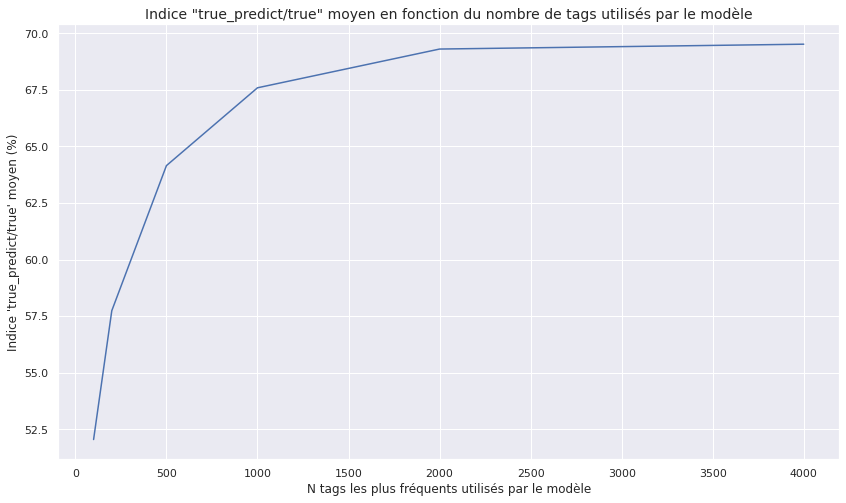

In [ ]:
# Regardons les métriques en fonction n_tags_min

plt.figure(figsize=(14,8))

X = [100, 200, 500, 1000, 2000, 4000]
plt.plot(X, df_resultats_reg_log_5['true_predict/true'])

#plt.xticks(range(0,25,5))
plt.xlabel('N tags les plus fréquents utilisés par le modèle')
plt.ylabel('Indice \'true_predict/true\' moyen (%)')
plt.title('Indice "true_predict/true" moyen en fonction du nombre de tags utilisés par le modèle', size=14)

plt.show()

### Avec un classifieur SVC

In [ ]:
# Optimisation 'vectorizer_type' bow ou tfidf :

params_grid = {'clf':[SVC], 'n_tags_selection':[150], 'n_tags_min':[5], 'vectorizer_type':['bow', 'tfidf'], 'min_df':[5]}
params_grid_clf = {'kernel':['linear'], 'penalty':[4], 'C':[4]}

df_resultats_svc_0 = model_test_params_2('df_resultats_svc_0', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_svc_0)

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"SVC {'C': 1, 'kernel': 'linear'}",150,5,bow,5,593.6219,20.0859,46.4620,2,2
0,"SVC {'C': 1, 'kernel': 'linear'}",150,5,tfidf,5,473.8538,23.1722,52.1523,1,1


In [ ]:
# # Optimisation 'min_df' :

# params_grid = {'clf':[SVC], 'n_tags_selection':[150], 'n_tags_min':[5], 'vectorizer_type':['tfidf'], 'min_df':list(range(1,4)) + list(range(4,11,2))}
# params_grid_clf = {'kernel':['linear'], 'C':[1]}

# df_resultats_svc_1 = model_test_params_2('df_resultats_svc_1', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

# with pd.option_context('max_colwidth', 100):
#     display(df_resultats_svc_1)

In [ ]:
# # Optimisation du paramètre 'C' de régularisation (norme l2 par défaut) :

# params_grid = {'clf':[SVC], 'n_tags_selection':[150], 'n_tags_min':[5], 'vectorizer_type':['tfidf'], 'min_df':list(range(1,4)) + list(range(4,11,2))}
# params_grid_clf = {'kernel':['linear'], 'C':[1]}

# df_resultats_svc_2 = model_test_params_2('df_resultats_svc_2', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

# with pd.option_context('max_colwidth', 100):
#     display(df_resultats_svc_2)

In [ ]:
# # Optimisation noyau :

# params_grid = {'clf':[SVC], 'n_tags_selection':[150], 'n_tags_min':[5], 'vectorizer_type':['tfidf'], 'min_df':list(range(1,4)) + list(range(4,11,2))}
# params_grid_clf = {'kernel':['linear', 'rbf'], 'C':[1]}

# df_resultats_svc_3 = model_test_params_2('df_resultats_svc_3', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False)

# with pd.option_context('max_colwidth', 100):
#     display(df_resultats_svc_3)

## D - Optimisation du modèle par validation croisée pour la regression logistique

Nous choisissons la regression logistique, qui offre des paramètres similaires au SVC mais qui a l'avantage d'offrir un modèle beaucoup moins lourd en temps de calcul.

### Choix du Vectorizer

In [ ]:
params_grid = {'n_tags_selection':[150], 'n_tags_min':[5], 'clf':[LogisticRegression], 'vectorizer_type':['bow', 'tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':[4]}

df_resultats_cv_0 = model_test_params_cv_2('df_resultats_cv_0', params_grid=params_grid, params_grid_clf=params_grid_clf, drop_affichage_KF=True, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_cv_0)


,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice_moy,true_predict/true_moy,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,bow,6,202.1083,22.4969,50.7653,2,2
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,75.4052,24.4551,54.1822,1,1


### Borne inf min_df des mots peu fréquents

In [ ]:
params_grid = {'n_tags_selection':[150], 'n_tags_min':[5], 'clf':[LogisticRegression], 'vectorizer_type':['tfidf'], 'min_df':[3,4,5,6,7,9]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':[4]}

df_resultats_cv_1 = model_test_params_cv_2('df_resultats_cv_1', params_grid=params_grid, params_grid_clf=params_grid_clf, drop_affichage_KF=True, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_cv_1)


,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice_moy,true_predict/true_moy,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,3,78.0874,24.4435,54.1691,5,4
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,4,77.4491,24.4661,54.1944,1,1
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,5,76.6875,24.4519,54.1594,4,5
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,76.7370,24.4551,54.1822,2,2
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,7,75.8835,24.4539,54.1709,3,3
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,9,75.5737,24.4219,54.0949,6,6


### Paramètres de régularisation

In [ ]:
params_grid = {'n_tags_selection':[150], 'n_tags_min':[5], 'clf':[LogisticRegression], 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':range(2,7)}

df_resultats_cv_3 = model_test_params_cv_2('df_resultats_cv_3', params_grid=params_grid, params_grid_clf=params_grid_clf, drop_affichage_KF=True, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_cv_3)


,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice_moy,true_predict/true_moy,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,72.4763,24.1755,53.6818,5,5
0,"LogisticRegression {'C': 3, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,74.3818,24.3862,54.0363,4,4
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,76.1360,24.4551,54.1822,1,1
0,"LogisticRegression {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,77.0645,24.4526,54.1678,2,2
0,"LogisticRegression {'C': 6, 'penalty': 'l2', 'solver': 'liblinear'}",150,5,tfidf,6,78.4704,24.4381,54.1369,3,3


In [ ]:
params_grid = {'n_tags_selection':[150], 'n_tags_min':[5], 'clf':[LogisticRegression], 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l1'], 'C':list(np.arange(1.5,3.5,0.25))}

df_resultats_cv_2 = model_test_params_cv_2('df_resultats_cv_2', params_grid=params_grid, params_grid_clf=params_grid_clf, drop_affichage_KF=True, recompute=False)

with pd.option_context('max_colwidth', 100):
    display(df_resultats_cv_2)


,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice_moy,true_predict/true_moy,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 1.5, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,78.5776,24.2322,53.7207,5,5
0,"LogisticRegression {'C': 1.75, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,80.3872,24.2617,53.7750,3,4
0,"LogisticRegression {'C': 2.0, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,82.3006,24.2734,53.8168,2,2
0,"LogisticRegression {'C': 2.25, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,84.4476,24.2888,53.8337,1,1
0,"LogisticRegression {'C': 2.5, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,85.4427,24.2554,53.8037,4,3
0,"LogisticRegression {'C': 2.75, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,86.7327,24.2074,53.7076,6,6
0,"LogisticRegression {'C': 3.0, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,86.9715,24.1410,53.6042,7,7
0,"LogisticRegression {'C': 3.25, 'penalty': 'l1', 'solver': 'liblinear'}",150,5,tfidf,6,88.7524,24.0688,53.4832,8,8


## E - Performances du modèle en fonction du nombre minimal de tags retournés dans le predict

In [ ]:
# Contrairement à précédemment on regarde le modèle sur toutes les données (le train/test sur les 49k et non les 20k)

params_grid = {'clf':[LogisticRegression], 'n_tags_selection':[2000], 'n_tags_min':range(11), 'vectorizer_type':['tfidf'], 'min_df':[6]}
params_grid_clf = {'solver' :['liblinear'], 'penalty':['l2'], 'C':[4]}

df_resultats_model_final = model_test_params_2('df_resultats_model_final', params_grid=params_grid, params_grid_clf=params_grid_clf, recompute=False, alldata=True)

display(df_resultats_model_final)

# On pourrait modifier la fonction predict pour ne pas avoir à tout recalculer...

,classifieur_binaire,n_tags_selection,n_tags_min,vectorizer_type,min_df,time,jaccard_indice,true_predict/true,rang_jaccard_indice,rang_true_predict/true
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,0,tfidf,6,373.9957,36.4384,39.9859,5,11
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,1,tfidf,6,389.8049,40.8254,44.3728,3,10
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,2,tfidf,6,358.4914,43.2007,52.7839,1,9
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,3,tfidf,6,362.1998,41.2270,60.5552,2,8
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,4,tfidf,6,367.3090,37.2545,65.9369,4,7
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,5,tfidf,6,364.4793,33.2831,69.5023,6,6
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,6,tfidf,6,359.2671,29.8295,72.1045,7,5
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,7,tfidf,6,363.3274,26.9252,74.0254,8,4
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,8,tfidf,6,369.8496,24.4187,75.3620,9,3
0,"LogisticRegression {'C': 4, 'penalty': 'l2', 'solver': 'liblinear'}",2000,9,tfidf,6,373.8708,22.4063,76.7115,10,2


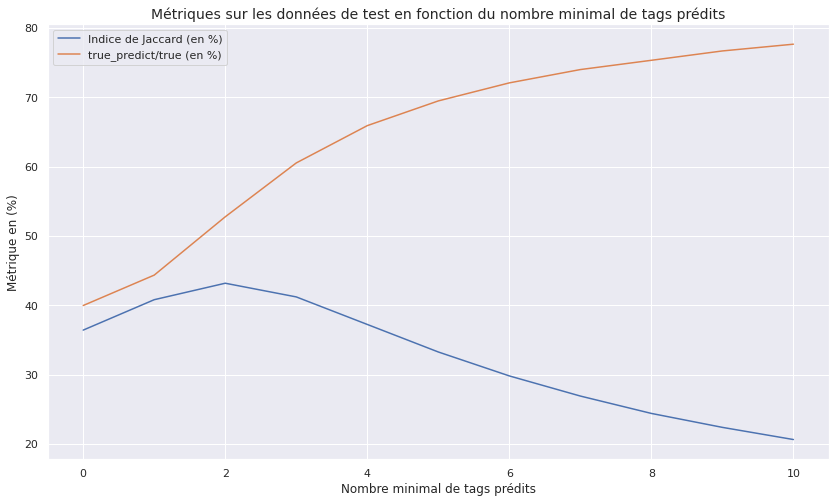

In [ ]:
# Regardons les métriques en fonction n_tags_min

plt.figure(figsize=(14,8))

X = range(11)
plt.plot(X, df_resultats_model_final.jaccard_indice)
plt.plot(X, df_resultats_model_final['true_predict/true'])

#plt.xticks(range(0,25,5))
plt.xlabel('Nombre minimal de tags prédits')
plt.ylabel('Métrique en (%)')
plt.title('Métriques sur les données de test en fonction du nombre minimal de tags prédits', size=14)
plt.legend(['Indice de Jaccard (en %)', 'true_predict/true (en %)'])

plt.show()



## F - Modèle choisi, visualisation des tags prédits

Voici les paramètres choisis pour le modèle final :

Nous choisissons les 2000 tags les plus fréquents, comme le montre le notebook d'exploration cela couvre plus de 90% des tags.  

Pour le nombre minimal de tags à renvoyer dans le predict nous nous fixons à 5, que nous estimons être une juste mesure entre un bon "true_predict/true" qui est proche de 70 % et trop de tags à renvoyer.  

La vectorisation du corpus 'tfidf' donne de meilleurs résultats que le 'bow', la différence est significative. 
Pour la borne inf du nombre d'occurences des mots peu fréquents dans le corpus, un petit nombre (entre 3 et 7), donne les meilleurs résultats. Nous choisissons min_df = 4.  

Enfin pour le classifieur nous choisissons la régression logistique avec une régularisation l2 et un coefficient de régularisation C=4.

Voici la visualisation des prédictions du modèle final :

In [ ]:
params = {'n_tags_selection':2000, 'n_tags_min':2, 'vectorizer_type': 'tfidf', 'min_df': 4, 'clf' :LogisticRegression(solver='liblinear', penalty='l2', C=4)}

recompute=False
nom_fichier = 'df_resultat_final_0'

if recompute or not os.path.isfile(chemin + nom_fichier): 
    df_resultat_final_0 = visualisation_resultats(df_train, df_test, params = params)
    df_resultat_final_0.to_pickle(path = chemin + nom_fichier)
else:
    df_resultat_final_0 = pd.read_pickle(filepath_or_buffer = chemin + nom_fichier)

df_resultat_final_0.rename(columns={'tags_liste':'tags_true'}, inplace=True)
df_resultat_final_0.head(5)

,tags_true,tags_predict_fct_decision >= 0,tags_predict,jaccard_indice,true_predict/true
33319,"[git, commit]",[git],"[git, git-commit]",33.3333,50.0000
748,[html],"[forms, html, javascript]","[forms, html, javascript]",33.3333,100.0000
40042,[r],[r],"[r, dataframe]",50.0000,100.0000
25288,"[php, string, split]","[php, string, split]","[php, string, split]",100.0000,100.0000
47848,"[mysql, sql, plsql]",[sql],"[sql, mysql]",66.6667,66.6667


In [ ]:
params = {'n_tags_selection':500, 'n_tags_min':5, 'vectorizer_type': 'tfidf', 'min_df': 4, 'clf' :LogisticRegression(solver='liblinear', penalty='l2', C=4)}

recompute=False
nom_fichier = 'df_resultat_final'

if recompute or not os.path.isfile(chemin + nom_fichier): 
    df_resultat_final = visualisation_resultats(df_train, df_test, params = params)
    df_resultat_final.to_pickle(path = chemin + nom_fichier)
else:
    df_resultat_final = pd.read_pickle(filepath_or_buffer = chemin + nom_fichier)


df_resultat_final.rename(columns={'tags_liste':'tags_true'}, inplace=True)
df_resultat_final.head(9)

,question_text,tags_true,tags_predict_fct_decision >= 0,tags_predict,jaccard_indice,true_predict/true
41226,How to read a CSV file into a .NET Datatable How can I load a CSV file into a System.Data.DataTa...,"[c#, net, csv, datatable]","[c#, csv, net]","[c#, csv, net, asp.net, datatable]",80.0000,100.0000
9030,How to access the content of an iframe with jQuery? How can I access the content of an iframe wi...,"[jquery, iframe]","[jquery, iframe, javascript]","[jquery, iframe, javascript, html, jquery-selectors]",40.0000,100.0000
2199,Best algorithm for detecting cycles in a directed graph What is the most efficient algorithm for...,"[algorithm, graph-theory, directed-graph]",[],"[algorithm, java, c++, javascript, c]",14.2857,33.3333
2161,How do you round a floating point number in Perl? How can I round a decimal number (floating poi...,"[perl, floating-point, rounding]","[rounding, floating-point]","[rounding, floating-point, math, numbers, perl]",60.0000,100.0000
40247,"How to set custom ActionBar color / style? I am using Android Navigation bar in my project,\nI w...","[android, colors, background, android-actionbar, navigation-drawer]","[android, android-actionbar]","[android, android-actionbar, colors, android-layout, css]",42.8571,60.0000
4497,How do you change the size of figures drawn with matplotlib? How do you change the size of figur...,"[python, graph, matplotlib, plot, visualization]","[matplotlib, python]","[matplotlib, python, java, android, c#]",25.0000,40.0000
33886,javax.websocket client simple example Can someone please provide me very simple example of webso...,"[java, websocket]",[],"[javascript, html, java, c#, node.js]",16.6667,50.0000
402,Removing numbers from string How can I remove digits from a string?\n,"[python, string]",[string],"[string, numbers, python, c#, java]",40.0000,100.0000
19015,"jQuery AJAX form using mail() PHP script sends email, but POST data from HTML form is undefined ...","[php, javascript, jquery, ajax, html]","[jquery, php, email, ajax, forms]","[jquery, php, email, ajax, forms]",42.8571,60.0000


In [ ]:
mask = df_resultat_final.question_text.apply(len) <= 150

with pd.option_context('max_colwidth', 200):
    display(df_resultat_final[mask].head())

,question_text,tags_true,tags_predict_fct_decision >= 0,tags_predict,jaccard_indice,true_predict/true
2161,How do you round a floating point number in Perl? How can I round a decimal number (floating point) to the nearest integer? \n\ne.g.\n\n1.2 = 1\n1.7 = 2\n\n,"[perl, floating-point, rounding]","[rounding, floating-point]","[rounding, floating-point, math, numbers, perl]",60.0,100.0
4497,How do you change the size of figures drawn with matplotlib? How do you change the size of figure drawn with matplotlib?\n,"[python, graph, matplotlib, plot, visualization]","[matplotlib, python]","[matplotlib, python, java, android, c#]",25.0,40.0
402,Removing numbers from string How can I remove digits from a string?\n,"[python, string]",[string],"[string, numbers, python, c#, java]",40.0,100.0
11753,insert datetime value in sql database with c# How do I insert a datetime value into a SQL database table where the type of the column is datetime?\n,"[c#, sql, datetime]","[c#, sql, sql-server, datetime]","[c#, sql, sql-server, datetime, sql-server-2005]",60.0,100.0
25366,Best GUI designer for eclipse? I'm looking for a good GUI designer for swing in eclipse. My preference is for a free/open-source plugin.\n,"[java, eclipse, swing, gui-designer]","[eclipse, user-interface]","[eclipse, user-interface, java, swing, ide]",50.0,75.0


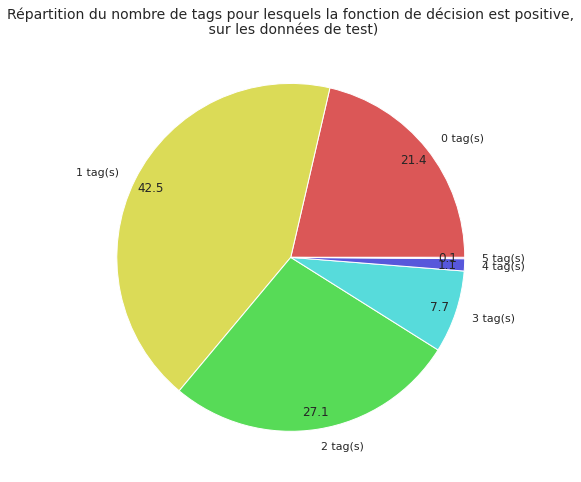

In [ ]:
# Nombre de tags pour lesquels la fonction de décision est positive

nb_tags = df_resultat_final['tags_predict_fct_decision >= 0'].apply(len).value_counts().sort_index()


fig = plt.figure(figsize=(8, 8))

plt.pie(nb_tags, labels=[str(n) + ' tag(s)' for n in nb_tags.index], colors=sns.hls_palette(n_colors=len(nb_tags), h=0.0), autopct='%.1f', pctdistance = 0.9)
plt.title('Répartition du nombre de tags pour lesquels la fonction de décision est positive,\n sur les données de test)', size=14)

plt.show()

In [ ]:
# Sauvegarde du modèle final entrainé sur toutes les données :

from joblib import dump, load

corpus = df_train.question_text_clean
target_tags = df_train.tags_liste

recompute=False
chemin_fichier = chemin + 'modele.joblib'
if recompute or not os.path.isfile(chemin_fichier): 
    modele = model_fit(corpus, target_tags, n_tags_selection=2000, clf=LogisticRegression(solver='liblinear', penalty='l2', C=4), vectorizer_type='tfidf', min_df=4)
    dump(modele, chemin_fichier)
else:
    modele = load(chemin + 'modele.joblib')

modele

(MultiOutputClassifier(estimator=LogisticRegression(C=4, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                       n_jobs=None),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 inp

In [ ]:
#df_test.question_text.to_pickle(path = chemin + 'questions_exemples')

In [ ]:
# Sauvegarde du modèle final entrainé sur toutes les données :

from joblib import dump, load

corpus = df_sample_train.question_text_clean
target_tags = df_sample_train.tags_liste

recompute=False
chemin_fichier = chemin + 'modele.joblib'
if recompute or not os.path.isfile(chemin_fichier): 
    modele = model_fit(corpus, target_tags, n_tags_selection=500, clf=LogisticRegression(solver='liblinear', penalty='l2', C=4), vectorizer_type='tfidf', min_df=4)
    dump(modele, chemin_fichier)
else:
    modele = load(chemin + 'modele_light.joblib')

modele